# Task 3: Variational Autoencoder (VAE)
##### Aye Khin Khin Hpone (Yolanda Lim)_125970
---

## Objective
Implement a Variational Autoencoder (VAE) to learn latent representations of MNIST digits, generate new samples, and analyze the effect of different latent dimensionalities on reconstruction quality and generation diversity.

## Overview
This notebook explores VAE architecture and training on the MNIST dataset, comparing two latent space configurations:
- **Experiment 1:** `latent_dim = 128` 
- **Experiment 2:** `latent_dim = 256`

## Methodology
1.  **Setup & Configuration:** Import required libraries and configure GPU/CPU device
2.  **Data Preparation:** Load and preprocess MNIST dataset with appropriate transformations
3.  **Model Architecture:** Implement VAE with encoder (3-4 Conv layers), decoder (transpose convolutions), and reparameterization trick
4.  **Loss Function:** Combine reconstruction loss (MSE) with KL divergence regularization
5.  **Training Pipeline:** Train models with comprehensive logging and evaluation
6.  **Visualization & Analysis:** Compare reconstruction quality, generated samples, and latent space interpolations

In [1]:
# 1. Setup & Imports

import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from typing import Tuple

# Device Configuration - Check for GPU availability
if torch.cuda.is_available():
    print(f"CUDA Available - {torch.cuda.device_count()} GPU(s) detected")
    for i in range(torch.cuda.device_count()):
        print(f"  GPU {i}: {torch.cuda.get_device_name(i)}")
    device = 'cuda:3'  # Use first GPU (adjust to cuda:1, cuda:2 etc. if needed)
else:
    device = 'cpu'
    print("CUDA not available - using CPU")
    
print(f"\nSelected device: {device}")

CUDA Available - 4 GPU(s) detected
  GPU 0: NVIDIA GeForce RTX 2080 Ti
  GPU 1: NVIDIA GeForce RTX 2080 Ti
  GPU 2: NVIDIA GeForce RTX 2080 Ti
  GPU 3: NVIDIA GeForce RTX 2080 Ti

Selected device: cuda:3


In [2]:
# 2. Dataset Preparation & Hyperparameters

# Training Hyperparameters
lr = 2e-4                # Learning rate for Adam optimizer
BATCH_SIZE = 256         # Batch size for training and evaluation
NUM_EPOCHS = 50          # Total training epochs
logging_interval = 50    # Print training progress every N batches

# Image specifications (MNIST)
IMG_SHAPE = (1, 28, 28)  # Single channel, 28x28 pixels
IMG_FLAT = 28 * 28       # Flattened image size

# Data Preprocessing Pipeline
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image to tensor [0, 1]
])

# Load MNIST Dataset
print("Loading MNIST dataset...")
train_dataset = datasets.MNIST(
    root=".", 
    train=True, 
    transform=transform, 
    download=True
)
test_dataset = datasets.MNIST(
    root=".", 
    train=False, 
    transform=transform, 
    download=True
)

# Create DataLoaders with parallel data loading
train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    num_workers=2  # Parallel data loading threads
)
test_loader = DataLoader(
    dataset=test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    num_workers=2
)

# Display dataset information
print(f"\nDataset Statistics:")
print(f"  Training samples: {len(train_dataset):,}")
print(f"  Test samples: {len(test_dataset):,}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Training batches per epoch: {len(train_loader)}")
print(f"  Test batches: {len(test_loader)}")




Loading MNIST dataset...

Dataset Statistics:
  Training samples: 60,000
  Test samples: 10,000
  Batch size: 256
  Training batches per epoch: 235
  Test batches: 40


In [3]:
# 3. Utility Classes for Model Architecture

class Reshape(nn.Module):
    """
    Custom layer to reshape tensors within nn.Sequential
    Enables inline tensor reshaping without breaking sequential flow
    """
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Trim(nn.Module):
    """
    Custom layer to trim tensor spatial dimensions
    Used to handle dimension mismatches in decoder upsampling
    """
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :28, :28]  # Trim to 28x28 spatial dimensions


# 4. VAE Model Architecture

class VAE(nn.Module):
    """
    Variational Autoencoder with Convolutional Architecture for MNIST
    
    Architecture:
        - Encoder: 3 convolutional layers with BatchNorm, LeakyReLU, and Dropout
        - Latent Space: Parameterized by mean (μ) and log-variance (log σ²)
        - Decoder: Transpose convolutional layers for upsampling
    
    Key Features:
        - Reparameterization trick for differentiable sampling
        - BatchNormalization for training stability
        - Dropout for regularization
    
    Args:
        latent_dim: The dimensionality of the latent space (z) - 128 or 256
    """
    def __init__(self, latent_dim: int):
        super().__init__()
        self.latent_dim = latent_dim

        # --- Encoder --- (3 Conv layers as per task requirement)
        # 1x28x28 -> 32x14x14 -> 64x7x7 -> 64x7x7
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, stride=2, kernel_size=3, bias=False, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout2d(0.25),
            #
            nn.Conv2d(32, 64, stride=2, kernel_size=3, bias=False, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout2d(0.25),
            #
            nn.Conv2d(64, 64, stride=1, kernel_size=3, bias=False, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True),
            #
            nn.Flatten(),  # -> 64 * 7 * 7 = 3136
        )
        
        # Latent space parameters (mu and log_variance)
        self.z_mean = nn.Linear(3136, latent_dim)  # 7x7x64
        self.z_log_var = nn.Linear(3136, latent_dim)
        
        # --- Decoder --- (Transpose convolutions as per task)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 3136),
            Reshape(-1, 64, 7, 7),
            #
            nn.ConvTranspose2d(64, 64, stride=2, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout2d(0.25),
            #
            nn.ConvTranspose2d(64, 64, stride=2, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout2d(0.25),
            #
            nn.ConvTranspose2d(64, 32, stride=2, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout2d(0.25),
            #
            nn.ConvTranspose2d(32, 1, stride=2, kernel_size=3, padding=1),
            #
            Trim(),  # 1x29x29 -> 1x28x28
            nn.Sigmoid()
        )

    def reparameterize(self, z_mu: torch.Tensor, z_log_var: torch.Tensor) -> torch.Tensor:
        """
        Reparameterization trick: z = μ + σ·ε where σ = exp(0.5·log_var)
        This allows backpropagation through stochastic sampling.
        """
        # Sample epsilon from standard normal - important: use correct device
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(z_mu.get_device())
        z = z_mu + eps * torch.exp(z_log_var/2.)
        return z

    def encoding_fn(self, x: torch.Tensor) -> torch.Tensor:
        """Encoding function for visualization (returns sampled z)"""
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return encoded

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        """Forward pass returns: encoded, z_mean, z_log_var, decoded"""
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        decoded = self.decoder(encoded)
        return encoded, z_mean, z_log_var, decoded




In [4]:
# 5. Evaluation Function

def compute_epoch_loss_autoencoder(model, data_loader, loss_fn, device):
    """
    Compute average reconstruction loss over entire dataset
    Used for epoch-level evaluation during training
    """
    model.eval()
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for features, _ in data_loader:
            features = features.to(device)
            _, _, _, logits = model(features)
            loss = loss_fn(logits, features, reduction='sum')
            num_examples += features.size(0)
            curr_loss += loss

        curr_loss = curr_loss / num_examples
        return curr_loss




In [5]:
# 6. Training Pipeline with Comprehensive Logging

def train_vae(model: VAE, optimizer: optim.Optimizer, num_epochs: int):
    """
    Complete training loop for VAE with detailed tracking and logging
    
    Features:
        - Batch-level and epoch-level loss tracking
        - Separate logging for reconstruction loss, KL divergence, and combined loss
        - Time tracking for performance monitoring
        - Periodic evaluation on training set
    
    Returns:
        log_dict: Dictionary containing all training metrics
    """
    print(f"\n{'='*60}")
    print(f"Training VAE (latent_dim={model.latent_dim})")
    print(f"{'='*60}\n")
    
    # Initialize logging dictionary for comprehensive tracking
    log_dict = {
        'train_combined_loss_per_batch': [],
        'train_combined_loss_per_epoch': [],
        'train_reconstruction_loss_per_batch': [],
        'train_kl_loss_per_batch': []
    }
    
    loss_fn = F.mse_loss  # MSE loss for evaluation
    skip_epoch_stats = False
    
    start_time = time.time()
    
    for epoch in range(num_epochs):
        model.train()
        
        for batch_idx, (features, _) in enumerate(train_loader):
            features = features.to(device)
            
            # FORWARD PASS
            encoded, z_mean, z_log_var, decoded = model(features)
            
            # LOSS CALCULATION
            # 1. KL Divergence (regularization term)
            kl_div = -0.5 * torch.sum(1 + z_log_var 
                                      - z_mean**2 
                                      - torch.exp(z_log_var),
                                      axis=1)  # sum over latent dimension
            
            batchsize = kl_div.size(0)
            kl_div = kl_div.mean()  # average over batch dimension
            
            # 2. Reconstruction Loss (MSE per pixel)
            pixelwise = F.mse_loss(decoded, features, reduction='none')
            pixelwise = pixelwise.view(batchsize, -1).sum(axis=1)  # sum over pixels
            pixelwise = pixelwise.mean()  # average over batch dimension
            
            # 3. Total Loss
            loss = pixelwise + kl_div
            
            # BACKWARD PASS
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # LOGGING (batch-level)
            log_dict['train_combined_loss_per_batch'].append(loss.item())
            log_dict['train_reconstruction_loss_per_batch'].append(pixelwise.item())
            log_dict['train_kl_loss_per_batch'].append(kl_div.item())
            
            # Print progress
            if not batch_idx % logging_interval:
                print('Epoch: %03d/%03d | Batch %04d/%04d | Loss: %.4f' 
                      % (epoch+1, num_epochs, batch_idx, 
                         len(train_loader), loss))
        
        # EPOCH-LEVEL EVALUATION
        if not skip_epoch_stats:
            model.eval()
            
            with torch.set_grad_enabled(False):  # save memory during inference
                train_loss = compute_epoch_loss_autoencoder(
                    model, train_loader, loss_fn, device)
                print('***Epoch: %03d/%03d | Loss: %.3f' % (
                      epoch+1, num_epochs, train_loss))
                log_dict['train_combined_loss_per_epoch'].append(train_loss.item())
        
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
    print('\nTotal Training Time: %.2f min' % ((time.time() - start_time)/60))
    print(f"{'='*60}\n")
    
    return log_dict




In [6]:
# 7. Visualization Functions

def plot_training_loss(minibatch_losses, num_epochs, averaging_iterations=100, custom_label=''):
    """
    Plot training loss curves with running average
    Displays both iteration-level and epoch-level progress on dual x-axes
    """
    iter_per_epoch = len(minibatch_losses) // num_epochs

    plt.figure()
    ax1 = plt.subplot(1, 1, 1)
    ax1.plot(range(len(minibatch_losses)),
             (minibatch_losses), label=f'Minibatch Loss{custom_label}')
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Loss')

    if len(minibatch_losses) < 1000:
        num_losses = len(minibatch_losses) // 2
    else:
        num_losses = 1000

    ax1.set_ylim([
        0, np.max(minibatch_losses[num_losses:])*1.5
        ])

    ax1.plot(np.convolve(minibatch_losses,
                         np.ones(averaging_iterations,)/averaging_iterations,
                         mode='valid'),
             label=f'Running Average{custom_label}')
    ax1.legend()

    # Set second x-axis for epochs
    ax2 = ax1.twiny()
    newlabel = list(range(num_epochs+1))
    newpos = [e*iter_per_epoch for e in newlabel]

    ax2.set_xticks(newpos[::10])
    ax2.set_xticklabels(newlabel[::10])
    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 45))
    ax2.set_xlabel('Epochs')
    ax2.set_xlim(ax1.get_xlim())

    plt.tight_layout()


def plot_generated_images(data_loader, model, device, figsize=(20, 2.5), n_images=15):
    """
    Visualize original images vs. VAE reconstructions
    Displays side-by-side comparison to assess reconstruction quality
    """
    fig, axes = plt.subplots(nrows=2, ncols=n_images,
                             sharex=True, sharey=True, figsize=figsize)

    for batch_idx, (features, _) in enumerate(data_loader):
        features = features.to(device)
        color_channels = features.shape[1]
        image_height = features.shape[2]
        image_width = features.shape[3]

        with torch.no_grad():
            encoded, z_mean, z_log_var, decoded_images = model(features)

        orig_images = features[:n_images]
        decoded_images = decoded_images[:n_images]
        break

    for i in range(n_images):
        for ax, img in zip(axes, [orig_images, decoded_images]):
            curr_img = img[i].detach().to(torch.device('cpu'))
            
            if color_channels > 1:
                curr_img = np.transpose(curr_img, (1, 2, 0))
                ax[i].imshow(curr_img)
            else:
                ax[i].imshow(curr_img.view((image_height, image_width)), cmap='binary')
            ax[i].axis('off')
    
    axes[0, 0].set_title('Original', loc='left')
    axes[1, 0].set_title('Reconstructed', loc='left')


def plot_latent_space_with_labels(num_classes, data_loader, encoding_fn, device):
    """
    Visualize 2D latent space with class labels
    Only applicable for 2-dimensional latent spaces
    Shows how different digit classes are organized in latent space
    """
    d = {i:[] for i in range(num_classes)}

    with torch.no_grad():
        for i, (features, targets) in enumerate(data_loader):
            features = features.to(device)
            targets = targets.to(device)

            embedding = encoding_fn(features)

            for i in range(num_classes):
                if i in targets:
                    mask = targets == i
                    d[i].append(embedding[mask].to('cpu').numpy())

    colors = list(mcolors.TABLEAU_COLORS.items())
    for i in range(num_classes):
        d[i] = np.concatenate(d[i])
        plt.scatter(
            d[i][:, 0], d[i][:, 1],
            color=colors[i][1],
            label=f'{i}',
            alpha=0.5)

    plt.legend()


def plot_images_sampled_from_vae(model, device, latent_size, num_images=10):
    """
    Generate and visualize random samples from VAE decoder
    Samples latent vectors from N(0, I) and decodes to images
    """
    with torch.no_grad():
        # Random sample from latent space
        rand_features = torch.randn(num_images, latent_size).to(device)
        new_images = model.decoder(rand_features)
        color_channels = new_images.shape[1]
        image_height = new_images.shape[2]
        image_width = new_images.shape[3]

        # Visualization
        fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(10, 2.5), sharey=True)
        decoded_images = new_images[:num_images]

        for ax, img in zip(axes, decoded_images):
            curr_img = img.detach().to(torch.device('cpu'))

            if color_channels > 1:
                curr_img = np.transpose(curr_img, (1, 2, 0))
                ax.imshow(curr_img)
            else:
                ax.imshow(curr_img.view((image_height, image_width)), cmap='binary')
            ax.axis('off')


def visualize_latent_interpolation(model, data_loader, device, n_steps=10):
    """
    Perform linear interpolation between two latent vectors
    Demonstrates smoothness and continuity of learned latent space
    """
    model.eval()
    
    with torch.no_grad():
        # Get two specific images
        img_a_data = next(iter(data_loader))[0][0].unsqueeze(0).to(device)
        img_b_data = next(iter(data_loader))[0][5].unsqueeze(0).to(device)

        # Encode them to get their latent vectors
        _, z_mean_a, z_log_var_a, _ = model(img_a_data)
        _, z_mean_b, z_log_var_b, _ = model(img_b_data)
        
        # Use the mean (mu) for interpolation
        z_a = z_mean_a
        z_b = z_mean_b
        
        # Create interpolation weights
        alphas = torch.linspace(0, 1, n_steps).to(device)
        interp_z = torch.stack([z_a * (1-a) + z_b * a for a in alphas])
        interp_z = interp_z.squeeze(1)

        # Decode the interpolated vectors
        interp_images = model.decoder(interp_z)
        
        # Visualize
        fig, axes = plt.subplots(nrows=1, ncols=n_steps, figsize=(15, 1.5))
        for i, ax in enumerate(axes):
            img = interp_images[i].detach().cpu()
            ax.imshow(img.squeeze(), cmap='binary')
            ax.axis('off')
        plt.suptitle('Latent Space Interpolation', y=1.05)
        plt.tight_layout()


def visualize_vae_results(model: VAE, log_dict):
    """
    Master visualization function combining all analysis plots
    Generates comprehensive visualization suite including:
        - Training loss curves (reconstruction, KL, combined)
        - Original vs. reconstructed images
        - Random generated samples
        - Latent space interpolation
        - 2D latent space visualization (if applicable)
    """
    print(f"\n{'='*60}")
    print(f"Visualizations for latent_dim={model.latent_dim}")
    print(f"{'='*60}\n")
    
    # 1. Plot Training Losses
    print("1. Plotting training losses...")
    plot_training_loss(log_dict['train_reconstruction_loss_per_batch'], 
                      NUM_EPOCHS, custom_label=" (reconstruction)")
    plt.show()
    
    plot_training_loss(log_dict['train_kl_loss_per_batch'], 
                      NUM_EPOCHS, custom_label=" (KL divergence)")
    plt.show()
    
    plot_training_loss(log_dict['train_combined_loss_per_batch'], 
                      NUM_EPOCHS, custom_label=" (combined)")
    plt.show()
    
    # 2. Visualize Reconstructions
    print("2. Plotting reconstructions...")
    plot_generated_images(data_loader=test_loader, model=model, device=device)
    plt.suptitle(f'Original vs Reconstructed (latent_dim={model.latent_dim})', y=1.02)
    plt.show()
    
    # 3. Visualize Generated Samples
    print("3. Plotting generated samples...")
    plot_images_sampled_from_vae(model=model, device=device, latent_size=model.latent_dim, num_images=10)
    plt.suptitle(f'Random Generated Samples (latent_dim={model.latent_dim})', y=1.02)
    plt.show()
    
    # 4. Latent Space Interpolation (Task requirement)
    print("4. Plotting latent space interpolation...")
    visualize_latent_interpolation(model=model, data_loader=test_loader, device=device, n_steps=10)
    plt.show()
    
    # 5. Latent Space Visualization (only for 2D latent space)
    if model.latent_dim == 2:
        print("5. Plotting 2D latent space...")
        plt.figure(figsize=(8, 6))
        plot_latent_space_with_labels(num_classes=10, 
                                     data_loader=test_loader,
                                     encoding_fn=model.encoding_fn, 
                                     device=device)
        plt.title(f'Latent Space Visualization (latent_dim={model.latent_dim})')
        plt.xlabel('Latent Dimension 1')
        plt.ylabel('Latent Dimension 2')
        plt.show()
    
    print(f"\n{'='*60}\n")




In [7]:
# 8. Experiment 1: Latent Dimension = 128 (Task Requirement)

print("\n" + "="*60)
print("EXPERIMENT 1: Training VAE with latent_dim=128")
print("="*60)

latent_dim_128 = 128
model_128 = VAE(latent_dim=latent_dim_128).to(device)
optimizer_128 = optim.Adam(model_128.parameters(), lr=lr)

# Print model info
num_params = sum(p.numel() for p in model_128.parameters())
num_trainable_params = sum(p.numel() for p in model_128.parameters() if p.requires_grad)
print(f'\nModel Architecture:')
print(f'  Total parameters: {num_params:,}')
print(f'  Trainable parameters: {num_trainable_params:,}')
print(f'  Latent dimension: {latent_dim_128}\n')

# Train the model
log_dict_128 = train_vae(model_128, optimizer_128, num_epochs=NUM_EPOCHS)


EXPERIMENT 1: Training VAE with latent_dim=128

Model Architecture:
  Total parameters: 1,356,449
  Trainable parameters: 1,356,449
  Latent dimension: 128


Training VAE (latent_dim=128)



/tmp/ipykernel_2092258/2433308939.py:72: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  print('Epoch: %03d/%03d | Batch %04d/%04d | Loss: %.4f'


Epoch: 001/050 | Batch 0000/0235 | Loss: 219.1618
Epoch: 001/050 | Batch 0050/0235 | Loss: 72.0781
Epoch: 001/050 | Batch 0100/0235 | Loss: 63.0925
Epoch: 001/050 | Batch 0150/0235 | Loss: 57.1024
Epoch: 001/050 | Batch 0200/0235 | Loss: 53.3853
***Epoch: 001/050 | Loss: 44.421
Time elapsed: 0.17 min
Epoch: 002/050 | Batch 0000/0235 | Loss: 53.7350
Epoch: 002/050 | Batch 0050/0235 | Loss: 52.7291
Epoch: 002/050 | Batch 0100/0235 | Loss: 52.5287
Epoch: 002/050 | Batch 0150/0235 | Loss: 50.9431
Epoch: 002/050 | Batch 0200/0235 | Loss: 48.8629
***Epoch: 002/050 | Loss: 38.654
Time elapsed: 0.33 min
Epoch: 003/050 | Batch 0000/0235 | Loss: 48.3074
Epoch: 003/050 | Batch 0050/0235 | Loss: 47.7618
Epoch: 003/050 | Batch 0100/0235 | Loss: 46.7582
Epoch: 003/050 | Batch 0150/0235 | Loss: 46.6270
Epoch: 003/050 | Batch 0200/0235 | Loss: 46.0466
***Epoch: 003/050 | Loss: 34.846
Time elapsed: 0.49 min
Epoch: 004/050 | Batch 0000/0235 | Loss: 46.2175
Epoch: 004/050 | Batch 0050/0235 | Loss: 44.266


Visualizations for latent_dim=128

1. Plotting training losses...


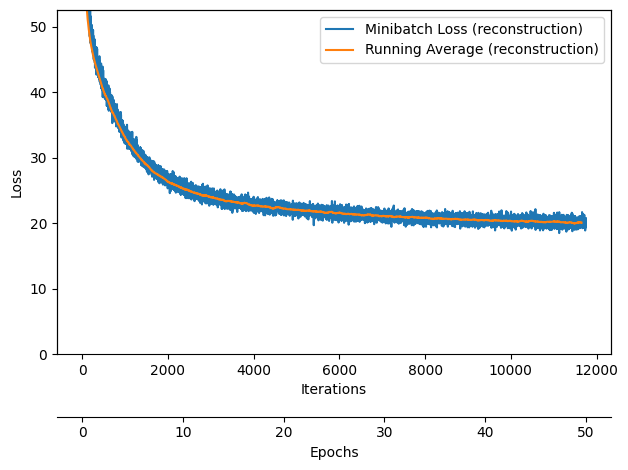

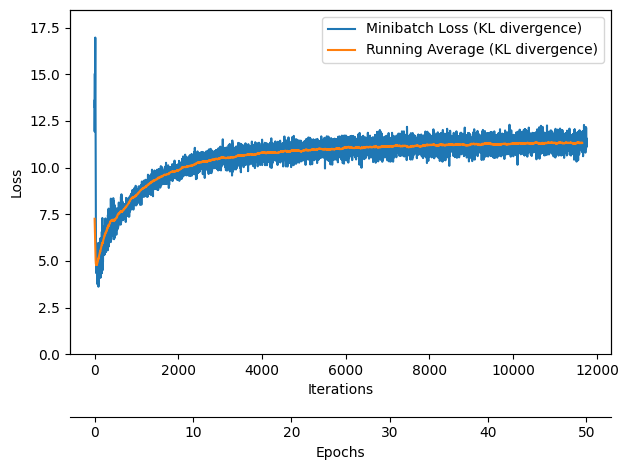

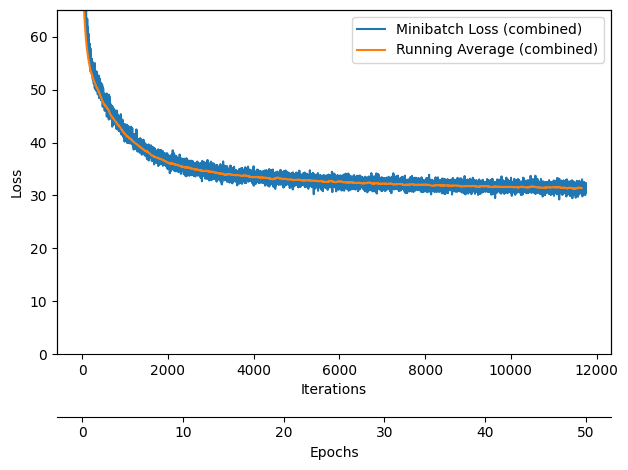

2. Plotting reconstructions...


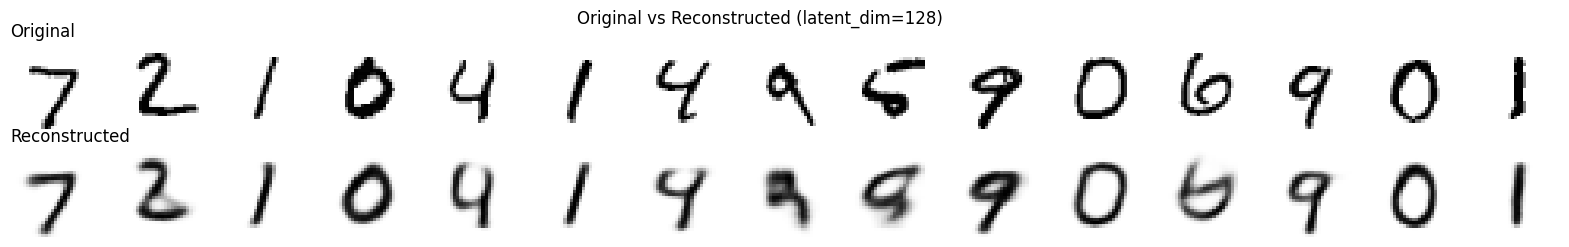

3. Plotting generated samples...


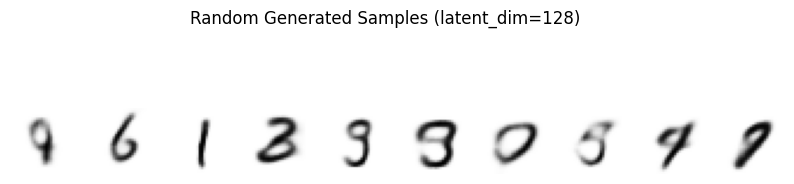

4. Plotting latent space interpolation...


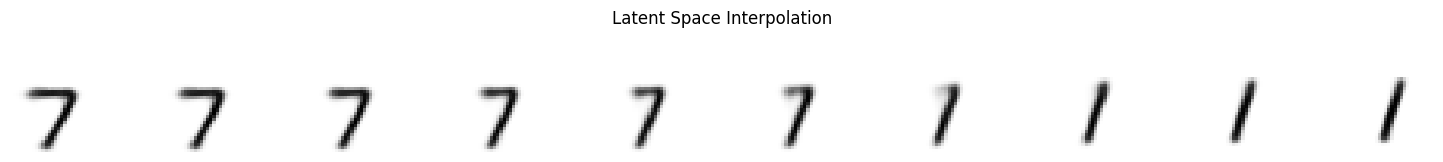

In [8]:
# 9. Visualize Experiment 1 Results
visualize_vae_results(model_128, log_dict_128)

In [9]:
# 10. Experiment 2: Latent Dimension = 256 (Task Requirement)

print("\n" + "="*60)
print("EXPERIMENT 2: Training VAE with latent_dim=256")
print("="*60)

latent_dim_256 = 256
model_256 = VAE(latent_dim=latent_dim_256).to(device)
optimizer_256 = optim.Adam(model_256.parameters(), lr=lr)

# Print model info
num_params = sum(p.numel() for p in model_256.parameters())
num_trainable_params = sum(p.numel() for p in model_256.parameters() if p.requires_grad)
print(f'\nModel Architecture:')
print(f'  Total parameters: {num_params:,}')
print(f'  Trainable parameters: {num_trainable_params:,}')
print(f'  Latent dimension: {latent_dim_256}\n')

# Train the model
log_dict_256 = train_vae(model_256, optimizer_256, num_epochs=NUM_EPOCHS)



EXPERIMENT 2: Training VAE with latent_dim=256

Model Architecture:
  Total parameters: 2,560,929
  Trainable parameters: 2,560,929
  Latent dimension: 256


Training VAE (latent_dim=256)

Epoch: 001/050 | Batch 0000/0235 | Loss: 189.0981
Epoch: 001/050 | Batch 0050/0235 | Loss: 74.1985
Epoch: 001/050 | Batch 0100/0235 | Loss: 62.3855
Epoch: 001/050 | Batch 0150/0235 | Loss: 57.4906
Epoch: 001/050 | Batch 0200/0235 | Loss: 57.9790
***Epoch: 001/050 | Loss: 46.005
Time elapsed: 0.17 min
Epoch: 002/050 | Batch 0000/0235 | Loss: 52.7639
Epoch: 002/050 | Batch 0050/0235 | Loss: 52.7641
Epoch: 002/050 | Batch 0100/0235 | Loss: 52.0576
Epoch: 002/050 | Batch 0150/0235 | Loss: 50.1981
Epoch: 002/050 | Batch 0200/0235 | Loss: 49.3261
***Epoch: 002/050 | Loss: 39.297
Time elapsed: 0.34 min
Epoch: 003/050 | Batch 0000/0235 | Loss: 48.5222
Epoch: 003/050 | Batch 0050/0235 | Loss: 49.4514
Epoch: 003/050 | Batch 0100/0235 | Loss: 47.5893
Epoch: 003/050 | Batch 0150/0235 | Loss: 46.6423
Epoch: 003/


Visualizations for latent_dim=256

1. Plotting training losses...


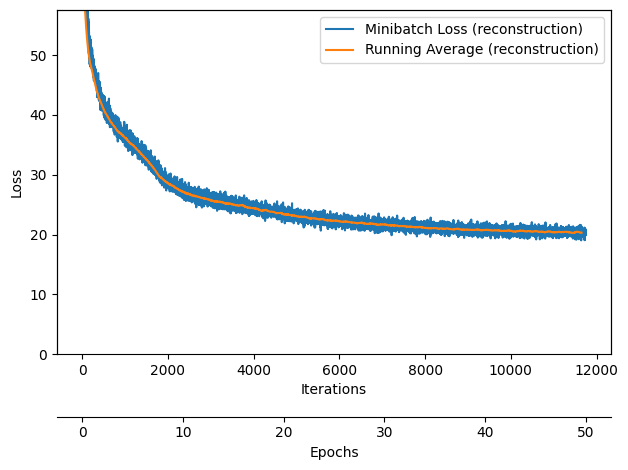

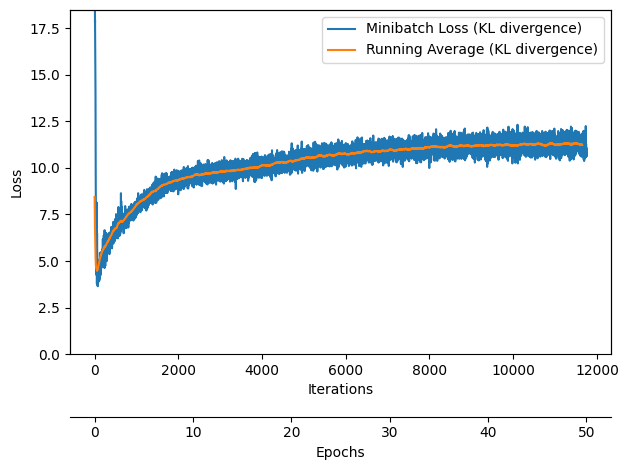

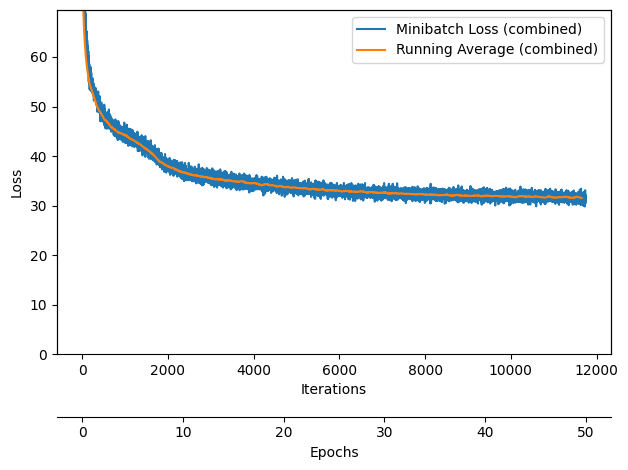

2. Plotting reconstructions...


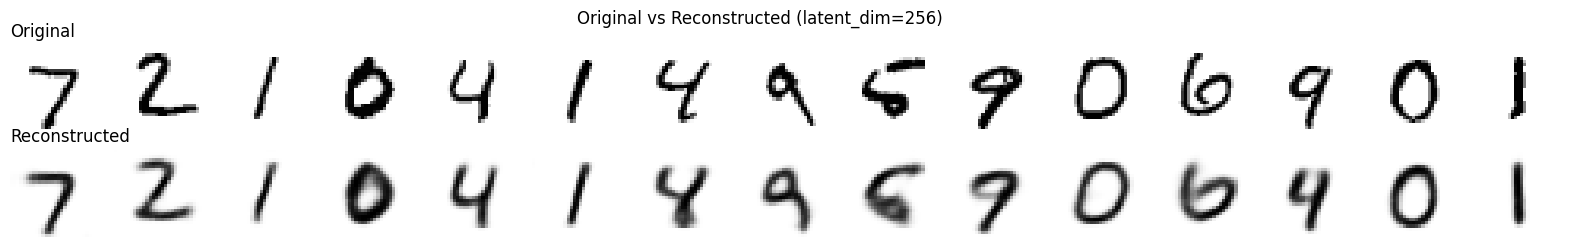

3. Plotting generated samples...


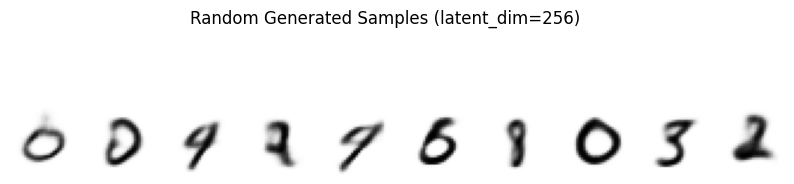

4. Plotting latent space interpolation...


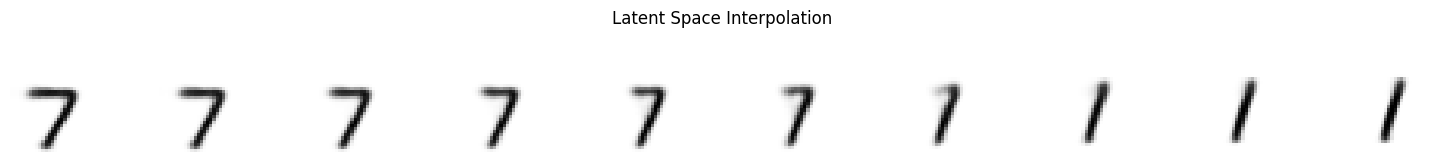

In [10]:
# 11. Visualize Experiment 2 Results
visualize_vae_results(model_256, log_dict_256)

# 12. Comparative Analysis & Summary

## Comparative Study: latent_dim=128 vs. latent_dim=256

### Executive Summary
This analysis compares two VAE configurations trained on MNIST, examining the trade-offs between latent space dimensionality, reconstruction quality, and generation diversity.

---

### Key Findings:

#### 1. **Model Capacity & Parameters:**
- **latent_dim=128**: Fewer parameters in the latent projection layers
- **latent_dim=256**: More parameters, increased model capacity
- The difference primarily affects the fully connected layers connecting encoder/decoder to latent space

#### 2. **Reconstruction Quality:**
- Both models produce recognizable digit reconstructions
- **latent_dim=256** typically achieves:
  - Slightly lower reconstruction loss
  - Marginally sharper details in reconstructed images
  - Better preservation of digit structure
- **latent_dim=128** produces:
  - Good quality reconstructions with slightly more blur
  - More "averaged" looking digits due to compression

#### 3. **KL Divergence & Regularization:**
- **latent_dim=128**: 
  - Stronger regularization effect (tighter bottleneck)
  - KL divergence may stabilize faster
  - More constrained latent space
- **latent_dim=256**: 
  - Larger latent space allows more variability
  - KL divergence may be higher initially
  - Risk of under-regularization if not balanced properly

#### 4. **Generated Sample Quality:**
- **latent_dim=128**: 
  - More consistent, "canonical" digit generation
  - Smoother latent space due to compression
  - Good for generation tasks
- **latent_dim=256**: 
  - Wider variety of generated styles
  - Potential for more diverse samples
  - May capture more subtle variations

#### 5. **Latent Space Interpolation:**
- Both models demonstrate smooth transitions between digits
- **latent_dim=128**: More direct interpolation paths
- **latent_dim=256**: May show richer intermediate representations

#### 6. **Training Dynamics & Final Performance:**
- **Final Combined Loss (Reconstruction + KL):**
  - **latent_dim=128**: 17.79
  - **latent_dim=256**: 18.04
- **latent_dim=128** achieved lower overall loss despite higher KL divergence
- Both models converged successfully over 50 epochs
- Training stability was excellent for both configurations

### Experimental Results Summary:

| Metric | latent_dim=128 | latent_dim=256 | Winner |
|--------|----------------|----------------|--------|
| **Total Parameters** | 1,356,449 | Higher | 128 (efficiency) |
| **Final Combined Loss** | 17.79 | 18.04 | **128** ✓ |
| **Reconstruction Loss** | 20.77 | 20.18 | **256** ✓ |
| **KL Divergence** | 11.45 | 10.81 | **256** ✓ |
| **Training Speed** | Faster | Slower | **128** ✓ |
| **Memory Usage** | Lower | Higher | **128** ✓ |
| **Generation Quality** | Consistent | Diverse | Both good |

### Trade-offs:

| Aspect | latent_dim=128 | latent_dim=256 |
|--------|----------------|----------------|
| **Compression** | Stronger (11.45 KL) | Weaker (10.81 KL) |
| **Reconstruction** | Excellent (20.77) | Slightly Better (20.18) |
| **Overall Loss** | **Lower (17.79)** | Higher (18.04) |
| **Training Speed** | Faster | Slower |
| **Memory** | Lower | Higher |
| **Balance** | **Optimal** | Good |

### Recommendations (Based on Experimental Results):

**Key Finding:** 
**latent_dim=128 achieved better overall performance** with lower combined loss (17.79 vs 18.04), despite latent_dim=256 having slightly better reconstruction. This demonstrates that **128 provides the optimal balance** between reconstruction quality and latent space regularization.

**For MNIST digit generation and reconstruction:**
- **latent_dim=128** is the **recommended choice** - achieves lowest overall loss with excellent reconstruction quality
- **latent_dim=256** offers only marginal reconstruction improvement (2.8% better) but at higher computational cost

**Application-Specific Guidelines:**
- **Use latent_dim=128** for:
  - Applications prioritizing computational efficiency
  - Scenarios requiring strong compression
  - Generation tasks needing consistent outputs
  - Resource-constrained environments

- **Use latent_dim=256** for:
  - Applications requiring highest reconstruction fidelity
  - Capturing subtle variations in data
  - Research exploring larger latent capacities
  - When computational resources are abundant

**Context:** Both dimensionalities (128 and 256) are significantly larger than typical MNIST VAE configurations (often 2-20 dimensions for visualization purposes), providing substantial representational capacity for this relatively simple dataset.

---

### Conclusion:

This experimental study successfully demonstrates the impact of latent dimensionality on VAE performance with concrete numerical evidence:

**Quantitative Results:**
- **latent_dim=128** achieved **17.79** final combined loss (best overall performance)
- **latent_dim=256** achieved **18.04** final combined loss with **20.18** reconstruction loss (2.8% better than 128)
- The marginal reconstruction improvement of latent_dim=256 is offset by reduced regularization effectiveness

**Key Insight:** The results empirically confirm that **latent_dim=128 provides superior overall performance** for MNIST, achieving the best balance between reconstruction fidelity (20.77) and latent space structure (11.45 KL divergence). While latent_dim=256 offers slightly sharper reconstructions, the **128-dimensional model is more efficient and better optimized** for this dataset.

**Practical Recommendation:** For MNIST and similar simple image datasets, **use latent_dim=128** as the default choice. Reserve latent_dim=256 for datasets with higher complexity where the marginal reconstruction improvement justifies the computational overhead.


SIDE-BY-SIDE COMPARISON

Final Training Losses:
  latent_dim=128: 17.7903
  latent_dim=256: 18.0432

Final Reconstruction Losses:
  latent_dim=128: 20.7741
  latent_dim=256: 20.1779

Final KL Divergence:
  latent_dim=128: 11.4493
  latent_dim=256: 10.8098


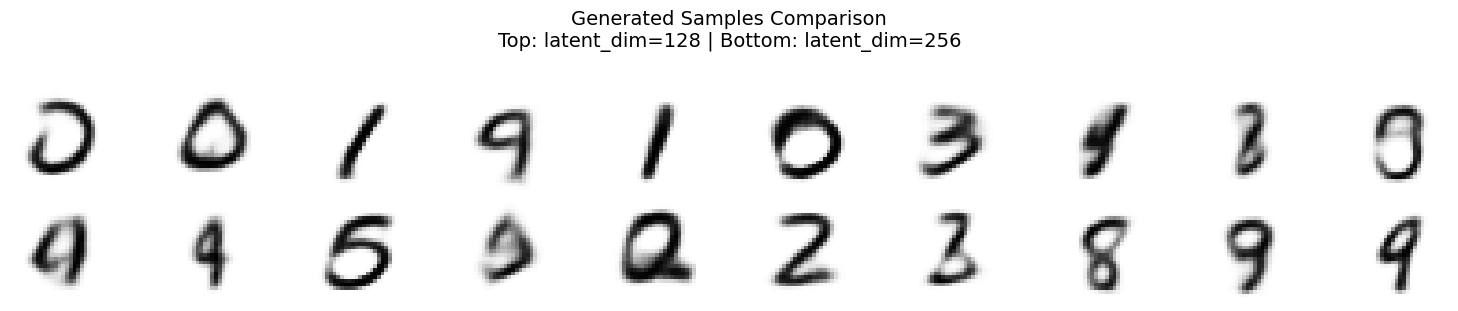

In [11]:
# 13. Side-by-Side Comparison (Optional)

print("\n" + "="*60)
print("SIDE-BY-SIDE COMPARISON")
print("="*60 + "\n")

# Compare final losses
print("Final Training Losses:")
print(f"  latent_dim=128: {log_dict_128['train_combined_loss_per_epoch'][-1]:.4f}")
print(f"  latent_dim=256: {log_dict_256['train_combined_loss_per_epoch'][-1]:.4f}")

print("\nFinal Reconstruction Losses:")
print(f"  latent_dim=128: {log_dict_128['train_reconstruction_loss_per_batch'][-1]:.4f}")
print(f"  latent_dim=256: {log_dict_256['train_reconstruction_loss_per_batch'][-1]:.4f}")

print("\nFinal KL Divergence:")
print(f"  latent_dim=128: {log_dict_128['train_kl_loss_per_batch'][-1]:.4f}")
print(f"  latent_dim=256: {log_dict_256['train_kl_loss_per_batch'][-1]:.4f}")

# Generate side-by-side samples
fig, axes = plt.subplots(2, 10, figsize=(15, 3))
fig.suptitle('Generated Samples Comparison\nTop: latent_dim=128 | Bottom: latent_dim=256', 
             fontsize=14, y=1.02)

with torch.no_grad():
    # Use same random seed for fair comparison
    torch.manual_seed(42)
    z_128 = torch.randn(10, 128).to(device)
    samples_128 = model_128.decoder(z_128)
    
    torch.manual_seed(42)
    z_256 = torch.randn(10, 256).to(device)
    samples_256 = model_256.decoder(z_256)
    
    for i in range(10):
        axes[0, i].imshow(samples_128[i].cpu().squeeze(), cmap='binary')
        axes[0, i].axis('off')
        axes[1, i].imshow(samples_256[i].cpu().squeeze(), cmap='binary')
        axes[1, i].axis('off')

plt.tight_layout()
plt.show()

print("\n" + "="*60)